# Week 6: Transfer learning and multitask learning

Deep neural networks can be **extremely expensive** to train. Training a good classifier on a complex task, like telling objects in images apart, or determining whether a move in a board game is good, can take weeks on multiple GPUs, cost millions of dollars in cloud computing fees and release massive amounts of CO$_2$ into the atmosphere ([some models more than 5 cars over their entire lifetimes](https://arxiv.org/pdf/1906.02243.pdf)). Because of this, we want to be able to **reuse** weights in models we have trained. This is called transfer learning. The fundamental idea is that things learned in one context can be *transferred* to another context.



## Exercises

We will follow a well-written [blog post](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/) by Jason Brownlee of 'Machine Learning 
Mastery' for most of these exercises. In his blog post, Jason takes the reader through
the process of using pretrained models in Keras. Below, the steps you
will go through are outlined with reference to his blog post. It is strongly recommend you read from the
top and down to 'Models for Transfer Learning' before proceeding.

### Loading pretrained models

The first practical thing we need to figure out when doing transfer learning is loading pretrained models. Keras makes this very easy by offering a number of pretrained models for image classification which can be downloaded through their [Applications API](https://keras.io/applications/#densenet). 

#### Applications API arguments

When loading pretrained models, we will want to provide some arguments that depend on what
we want to do with the model after loading. Below I ask you to explain, in your own words,
what some of these parameters do. See the Application API reference on some of the models
and the 'Models for Transfer Learning' section in Jason's blog post for help.

> **Ex. 6.1.1**: In your own words, explain what the following function arguments do in
the different model loading functions:
1. `include_top` When this is set to 'False' the model's output layer can be replaced by a new output layer can be used and trained instead. When it's 'True', it does include the output layer such that the model is fully connected. 
1. `weights` This parameter specifies the weights you initialize your model with. The default, 'imagenet', uses pre-trained weights. Setting the parameter to 'None' uses random weights so you can train your model from scratch
1. `input_shape` This parameter specifies the shape of the input data for our model. The first two elements of the tuple are the height and width, repsectively. The last element is the number of channels for our data. If we are dealing with colored images, we will likely have 3 channels, one for each in rgb. 
1. `pooling` This parameter allows you to add a pooling layer into your model. For example, you can add a global average pooling layer by setting the parameter to 'avg' and a global max pooling layer by setting it to 'max'.
1. `classes` This parameter sets the number of classes you have in your dataset; consequently, this determines the number of neurons in your output layer, one for each class. 

#### Load a model and predict an image

> **Ex. 6.1.2**: Following Jason's example under 'Pre-Trained Model as Classifier'
classify [this image](https://images.squarespace-cdn.com/content/v1/58f0ecc029687fbef7b86b03/1583064484458-IM0UKAZIONS6E2CFCDJC/ke17ZwdGBToddI8pDm48kD5ENJpXCfmjfXuRxqpPb-1Zw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpyN2spBBImrH38afc2UL8XBF0s2RHqmX-QW0wG37RpCsIsNysB0CO3b7e86dkNKVNs/Otter+Makes+an+Immediate+U-Turn+Back+to+the+Water.jpg?format=1500w).
Print not just the most likely label, but everything that `decode_predictions` returns. Depending on your tensorflow version you would have use `tensorflow.keras.utils` in stead of `tensorflow.keras.preprocessing.image`
>
> ***Important***: *The VGG16 model he uses is 500 MB to download, and will take quite long to load and apply.
> Rather use one of the smaller models instead ([here](https://keras.io/applications/#documentation-for-individual-models)'s an overview of model sizes), such as DenseNet121.*

In [1]:
# example of using a pre-trained model as a classifier
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
# load an image from file
image = load_img('otter.jpeg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model
model = VGG16()
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

1/1 [==============================] - 0s 188ms/step
limpkin (22.87%)


2024-03-18 20:14:19.051046: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [3]:
decode_predictions(yhat)

[[('n02013706', 'limpkin', 0.22866301),
  ('n02137549', 'mongoose', 0.14371373),
  ('n02454379', 'armadillo', 0.04674275),
  ('n02012849', 'crane', 0.041792378),
  ('n02447366', 'badger', 0.0395942)]]

Wow, this model sucks.

### Adapting pretrained models

#### Feature extractor for ML prediction

By removing the last layer, we can turn a pretrained convolutional neural network into a
*feature extractor*. We can then use it to extract features of a large number of images and
classify those using any machine learning model. Jason describes this under 'Pre-Trained Model as Feature Extractor Preprocessor'.

> **Ex. 6.2.1:** Say you've have been out all day taking pictures of cats and dogs (or maybe it's just a subset from [kaggle.com/c/dogs-vs-cats](https://www.kaggle.com/c/dogs-vs-cats)) but you haven't managed to take very many pictures and label them because it's hard work. This makes it hard to train a model of the size needed in order to tell the difference between dogs and cats. Download the data from canvas (Module 6, *ex6_cats_and_dogs.zip*) and 
> - Visualize some random images
> - Then train a logistic regression classifier on the **raw data**, i.e. every pixel value is a feature, and report the accuracy on the test data
>
>Below is some code that loads and splits the data into training and test data, then flattens the images into the data-matrix format.
>
> *Hint: You can import logistic regression from sklearn. It has a simple API where you basically only need the `.fit` and `.predict` methods of the logistic regression object. You can check out one of the examples on the [documentation page](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).*

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import os

In [5]:
X = np.load(os.path.join('cats_and_dogs', 'X_cat_vs_dog.npz'))['arr_0']
Y = np.load(os.path.join('cats_and_dogs', 'Y_cat_vs_dog.npz'))['arr_0']

# Split train/test
x_train = X[0:500]
y_train = Y[0:500]
x_test = X[500:]
y_test = Y[500:] 

# Flattens the images into the data-matrix format that most sklearn models accept
x_raw_train = x_train.flatten().reshape([x_train.shape[0], 200*200*3])
x_raw_test = x_test.flatten().reshape([x_test.shape[0], 200*200*3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


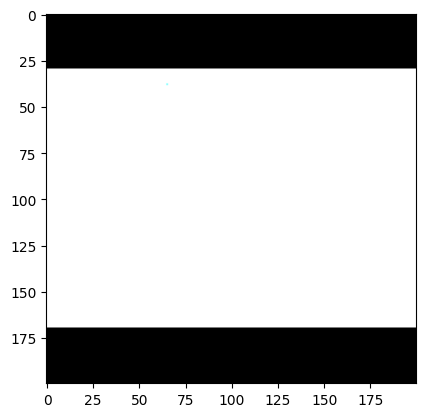

In [6]:
# Visualize first image
plt.imshow(X[0])

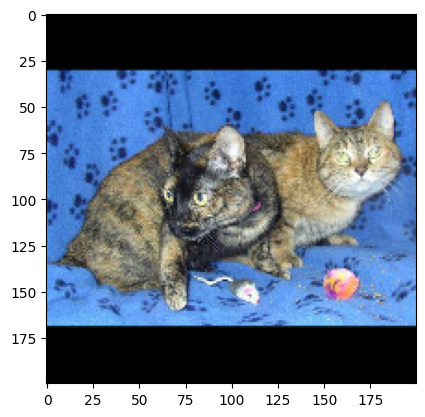

In [7]:
# Normalize, then visualize first image
plt.imshow(X[0]/255)

This is a cat


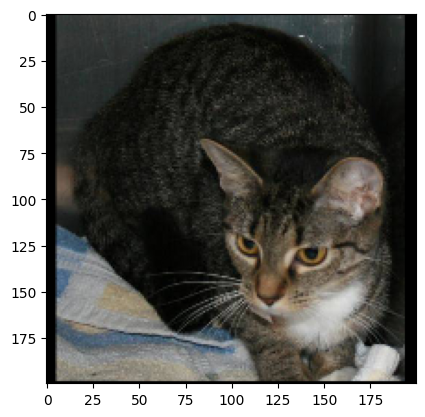

In [8]:
# Display random cat/dog
random_image = np.random.randint(len(Y))
plt.imshow(X[random_image,:,:,:]/255)
print('This is a %s' %( {0:'dog', 1:'cat'}[Y[random_image]] ) )

In [9]:
lr = LogisticRegression(max_iter=500)
lr.fit(x_raw_train, y_train)

LogisticRegression(max_iter=500)

In [10]:
predictions = lr.predict(x_raw_test)==y_test
sum(predictions/len(predictions))

0.5240000000000004

The logistic regression model has an accuracy of 52.4%, within the error of margin for guessing. 

> **Ex. 6.2.2:** Now, extract features for each datapoint, using a pre-trained neural network, thus building train and test input matrices `x_train_FE` and `x_test_FE`. Train a logistic regression classifier on the learned features, and report the accuracy on the test data.
You should be getting a significantly better performance than when using the raw data.
>
> Explain why that is; what work did the pretrained network do for you to be able to use the most simple classifier and get such great performance on a clearly nonlinear problem?

In [11]:
# Depending on whether the people who first developed the neural network normalized the data while training

feature_model = VGG16(include_top=False, input_shape=(200, 200, 3))
x_train_FE = feature_model.predict(preprocess_input(x_train))
x_test_FE = feature_model.predict(preprocess_input(x_test))

x_train_FE = x_train_FE.reshape((x_train_FE.shape[0], -1))
x_test_FE = x_test_FE.reshape((x_test_FE.shape[0], -1))
#x_train /= 255
#x_test /= 255

16/16 [==============================] - 37s 2s/step


In [12]:
feature_lr = LogisticRegression(max_iter=1000)
feature_lr.fit(x_train_FE, y_train)

# Predict on test data
y_pred = feature_lr.predict(x_test_FE)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

In [13]:
print(accuracy)

0.954


Extracting and using the learned features led to better performance because the pretrained model has already identified generic features that can pertain to cats and dogs. Now, the simple classifier has an easier job because it now only needs to learn which traits can differentiate a cat versus a dog.

#### Changing the prediction task (switching out the last layer)

Another way to achieve roughly the same thing is to remove the last layer and insert a new one with a different number of outputs. In this case we just need a single output neuron, as we only have 2 classes. 

> **Ex. 6.2.3**: Solve the same classification problem as above, but by following Jason's example under 'Pre-Trained Model as Feature Extractor in Model'. 
> - Use a max-pooling layer when you load the pre-trained model, and
> - only add a single output layer.
> 
> Compare to the accuracy you got in 6.2.2.
>
> *Hint: You might not want to train the entire neural network. You can freeze the weights of layer `i` using `model.layers[i].trainable = False` which can reduce the number of computations needed.

In [17]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers

model = VGG16(include_top=False, input_shape=(200, 200, 3), pooling='max')

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)

model = Model(inputs=model.inputs, outputs=output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

for ind in range(0,19):
    model.layers[ind].trainable = False
    
model.compile(optimizer="Adam", loss="BinaryCrossentropy", metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)


Epoch 1/5
16/16 [==============================] - 35s 2s/step - loss: 16.6629 - accuracy: 0.7540
Epoch 2/5
16/16 [==============================] - 36s 2s/step - loss: 2.3112 - accuracy: 0.9240
Epoch 3/5
16/16 [==============================] - 36s 2s/step - loss: 0.6671 - accuracy: 0.9580
Epoch 4/5
16/16 [==============================] - 36s 2s/step - loss: 0.1232 - accuracy: 0.9820
Epoch 5/5
16/16 [==============================] - 36s 2s/step - loss: 0.1156 - accuracy: 0.9820


In [19]:
y_pred = model.predict(x_test)

16/16 [==============================] - 35s 2s/step


In [20]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 36s 2s/step - loss: 0.9151 - accuracy: 0.9540


[0.9151288866996765, 0.9539999961853027]

Using 'Pre-Trained Model as Feature Extractor in Model' as a guideline, we achieved an accuracy of 0.954 on the test data. This was basically the same as the accuracy we got in 6.2.2 (0.954). If we had put in more training epochs and employed a regularization technique for the 6.2.3 model, we may have gotten better results (but using VGG16 instead of Densenet121 was srsly taking a long time and draining my battery).